In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stripROtools
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import crystalball

from stripROtools import colors
from stripROtools import GetTransErrs
from stripROtools import Mismeasurment_vs_z
from stripROtools import random_three_vector
from stripROtools import plot_track

In [151]:
# Solid angle range in theta [degrees]
theta_min = 15
theta_max = 30

# dataframe with time offset info used for 3D reconstruction
T_off = pd.read_pickle("./data/time_offset.pk")
T_off

,Name,Mu,Mu_err,Sigma,Sigma_err
0,UH DLC a,-6.684141,0.031719,16.382493,0.024764
1,UH DLC b,-5.208232,0.034228,16.305925,0.026783
2,UH DLC c,6.752723,0.038583,14.113659,0.031446
3,UH DLC d,6.852294,0.058807,14.800689,0.048234
4,UH NoDLC a,5.703480,0.075588,19.574833,0.061573
5,UH NoDLC b,5.473110,0.114114,19.799337,0.092169
6,UH NoDLC c,25.241775,0.189180,18.082547,0.159142
7,UH NoDLC d,20.674842,0.698955,17.886667,0.626167
8,UoS,-11.400385,0.026963,15.290716,0.021079


# Read dE/dx data from SRIM

In [152]:
# Load dEdx data simulated with SRIM
dEdx_data = np.loadtxt("./data/srim_po210_heco2.txt",skiprows=4)

dEdx_data = dEdx_data.T

# convert from angstrom to cm
dEdx_data[0] = dEdx_data[0]*1e-8

#dEdx resolution as seen in dEdx_data[0] 
delta_x = 0.1

# convert to eV/cm
dEdx_data[1] = dEdx_data[1]/1e-8
dEdx_data[2] = dEdx_data[2]/1e-8

dEdx = dEdx_data[1] + dEdx_data[2]




Text(0, 0.5, 'dE/dx [eV/cm] ')

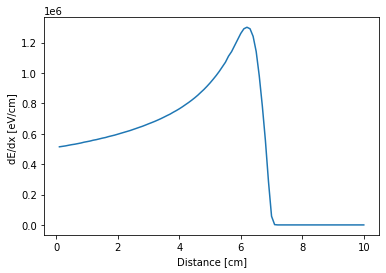

In [153]:
plt.plot(dEdx_data[0],dEdx)
plt.xlabel("Distance [cm]")
plt.ylabel("dE/dx [eV/cm] ")


# Simulate Po210 alpha tracks

This makes lines of ionization with the dEdx specified by SRIM. The tracks start at the cathode and travel downwards within a specified solid angle.

In [154]:
# The paramters, in order, are:
# number of simulations
# minimum angle to vertical [degrees] - this is based  on requiring a min. of 5 hits
# maximum angle to vertical [degrees]
# drfit length [cm]
# W-value as obtained using degrad for 70% He 30% CO2

def sim_p210(n_sims = 100, theta_min = theta_min, theta_max = theta_max, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2):

    tracks = pd.DataFrame(columns = ['init_dir', 'init_pos', 'track'])

    for i in range(n_sims):

        # draw a random direction within specified solid angle (pointing down towards the readout plane)
        v = random_three_vector(theta_min,theta_max)

        # Maximumm track length of alpha track
        L_max = -DL/v[2]

        # Length segments we will distribute charge on, 0.1 is the resolution of length of the SRIM simulation
        L_segments = np.arange(0,L_max+0.1,0.1)

        # Edges of the length segments we will distribute charge on (all edges are listed)
        L_edges = np.append(L_segments,L_max)

        # Energy deposited in each segment given dEdx (energy in each bin is listed)
        E_segments = dEdx[0:len(L_segments)]*np.diff(L_edges)

        # Compute corresponding number of ionizaed eletrons using energy deposited per segment divided by W-value
        Ne_segments = np.round(E_segments/W).astype("int")

        #find left and right edges for each bin
        Left_edges = L_segments[0:-1]
        Right_edges = L_segments[1:]

        track = np.empty((0,3))

        for N,left_edge,right_edge in zip(Ne_segments,Left_edges,Right_edges):

            Ts = np.random.uniform(low=left_edge,high=right_edge,size=N)

            x_vals = Ts*v[0]
            y_vals = Ts*v[1]
            z_vals = DL + Ts*v[2]

            Track_segment = np.array([x_vals,y_vals,z_vals]).T

            track = np.append(track,Track_segment,axis=0)

        x_rand = np.random.uniform()-0.5
        y_rand = np.random.uniform()-0.5

        track[:,0] = track[:,0]+x_rand # randomize x position (1 cm random uniform dist)
        track[:,1] = track[:,1]+y_rand # randomize y position (1 cm random uniform dist)

        tracks = tracks.append({'init_dir' : v, 'init_pos' : np.array([x_rand,y_rand,DL]), 'track' : track }, ignore_index = True)

    return tracks




In [155]:
# Example of track simulation
tracks = sim_p210(n_sims = 100)
tracks.head()

,init_dir,init_pos,track
0,"[-0.10401085416421178, 0.32812437872444544, -0...","[-0.11457631859498452, 0.08817812108187428, 1.2]","[[-0.11746766590580622, 0.09729949161251267, 1..."
1,"[-0.37178190760461555, -0.07997733287131588, -...","[0.2204140930795807, 0.2986525999707065, 1.2]","[[0.19246776881826894, 0.2926408160934942, 1.1..."
2,"[-0.2627727371468793, -0.07544547894946105, -0...","[-0.01932586442703743, -0.45853259451759254, 1.2]","[[-0.021186028949830717, -0.45906667200550366,..."
3,"[-0.018672155781053818, 0.3369978048144375, -0...","[-0.1500474491855075, -0.1574680893332182, 1.2]","[[-0.1504638026255245, -0.1499536814117163, 1...."
4,"[0.42606399783837395, -0.2275718783260976, -0....","[-0.10743981941597247, -0.03829705129038097, 1.2]","[[-0.10699406844250356, -0.03853513849514988, ..."


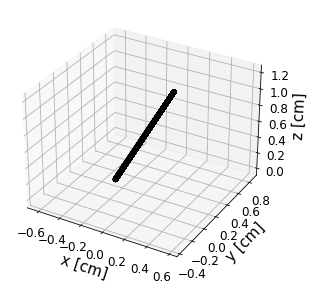

In [156]:
# Plot a Track
index = 1
track = tracks.iloc[index]["track"]
plot_track(track)

# Add diffusion to raw tracks

In [157]:
# The paramters, in order, are:
# tracks, a dataframe with the raw track info
# Transverse diffusion coefficent for 70% He 30% CO2 from Magboltz [cm/sqrt(cm)]
# Longitudinal diffusion coefficent for 70% He 30% CO2 from Magboltz [cm/sqrt(cm)]

def add_diff(tracks, DTrans = 0.0135, DLong = 0.0129):

    tracks["diff_track"] = tracks.apply(lambda row: row.track + np.array([DTrans*np.sqrt(np.abs(row.track.T[2]))*np.random.normal(size=len(row.track)),DTrans*np.sqrt(np.abs(row.track.T[2]))*np.random.normal(size=len(row.track)),DLong*np.sqrt(np.abs(row.track.T[2]))*np.random.normal(size=len(row.track))]).T ,axis=1)
    return tracks 

    

In [158]:
tracks = add_diff(tracks, DTrans = 0.0135, DLong = 0.0129)

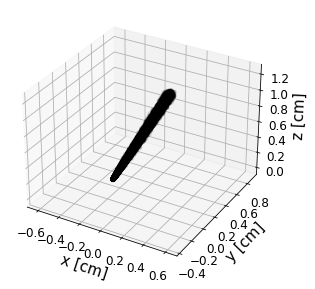

In [159]:
# Plot a Track
index = 1
track = tracks.iloc[index]["diff_track"]
plot_track(track)

# Simulate readout


Simulates a 10 cm x 10 cm readout plane in the xy-plane centered at the origin

In [162]:
# the parameters, in order, are:
# peaking time [ns]
# digitization time [ns] 
# pitch of the x strips [um]
# pitch of the y strips [um]
# Threshold of x strips [No. electrons]
# Threshold of y strips [No. electrons]
# Charge sharing [lower strips / upper strips]
# Gain - extrapolating from PHA curve
# drift speed cm/ns
# Include charge integration effect.
# z resolution in cm, must be specified if Charge_integration = False
# Electronic gain in x [mV/fC]
# Electronic gain in y [mV/fC]

def sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = 200, pitch_y = 200,thres_x = 82/9.0*6241.5, thres_y =  82/4.5*6241.5, CS = 0.62, Gain = 604, v_drift = 0.0008, Charge_integration = True, DL = 1.2, pitch_z = 0.02, G_x = 9.0, G_y = 4.5):

    #convert pitch to cm
    pitch_x = pitch_x * 1e-4
    pitch_y = pitch_y * 1e-4
    
    # Readout is 10 cm x 10 cm
    x_bins = np.arange(-5,5,pitch_x)
    y_bins = np.arange(-5,5,pitch_y)

    # Find strip edges in x and y
    Left_edges_x = x_bins[0:-1]
    Right_edges_x = x_bins[1:]
    Left_edges_y = y_bins[0:-1]
    Right_edges_y = y_bins[1:]


    hits = pd.DataFrame(columns = ['strips_x', 'strips_y', 'times_x', 'times_y','electrons_x','electrons_y'])

    for index, row in tracks.iterrows():

        track = row.diff_track
        #Keep only point above the xy-plane (points below it do not get amplified)
        track = track[track[:,2]>0]

        x_positions = []
        x_charges = []
        x_times = []
        adcs0 = []
        strips0 = []

        for L_edge,R_edge in zip(Left_edges_x,Right_edges_x):

            # Bin track over specific strip in x
            T_track = track[(track[:,0]> L_edge) &  (track[:,0]< R_edge)] 

            # If there is charge above this strip
            if len(T_track > 0):

                # Get time distribution of charge over this strip
                time_dist = T_track[:,2]/v_drift

                # Create all hits for this strip taking into account the peaking time and the digitization time 
                while len(time_dist) > 0:

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # This hit will only contain charge arriving within the peaking time
                    time_dist_hit = time_dist [time_dist < peaking_time]

                    # compute mean time for this hit
                    mean_time = np.mean(time_dist_hit)+min_time

                    # obtain detected charge for this hit taking into account primary ionization, gain, and charge sharing
                    # This is a simple prelminary tratement for the gain that should be improved in the future 
                    charge_detected = len(time_dist_hit) *Gain * CS / (CS+1.0)

                    # only store infor for the hit if the charge detected exceeds the threshold
                    if charge_detected > thres_x:
                            
                        # obtain mean time for the hit
                        x_times += [mean_time]
                        # obtain position of the hit
                        x_positions += [ (L_edge+R_edge)/2.0 ]
                        # Position expressed consistently with exp digitized data
                        strips0 += [np.where(x_bins == L_edge)[0][0]]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        x_charges += [ charge_detected ]
                        # Charge expressed consistently with exp digitized data
                        adcs0 += [min( charge_detected/6241.5*G_x, 1023.0 ) ]

                    # The time distribution is updated to take into account the digitization time
                    time_dist = time_dist[ time_dist > (peaking_time+digit_t) ] + min_time

        

        y_positions = []
        y_charges = []
        y_times = []
        adcs1 = []
        strips1 = []

        for L_edge,R_edge in zip(Left_edges_y,Right_edges_y):

            # Bin track over specific strip in x
            T_track = track[(track[:,1]> L_edge) &  (track[:,1]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):

                # Get time distribution of charge over this strip
                time_dist = T_track[:,2]/v_drift

                # Create all hits for this strip taking into account the peaking time and the digitization time 
                while len(time_dist) > 0:

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # This hit will only contain charge arriving within the peaking time
                    time_dist_hit = time_dist [time_dist < peaking_time]

                    # compute mean time for this hit
                    mean_time = np.mean(time_dist_hit)+min_time

                    # obtain detected charge for this hit taking into account primary ionization, gain, and charge sharing
                    # This is a simple prelminary tratement for the gain that should be improved in the future 
                    charge_detected = len(time_dist_hit) * Gain / (CS+1.0)

                    if charge_detected > thres_y:

                        # obtain mean time for the hit
                        y_times += [mean_time]
                        # obtain position of the hit
                        y_positions += [ (L_edge+R_edge)/2.0 ]
                        # Position expressed consistently with exp digitized data
                        strips1 += [np.where(y_bins == L_edge)[0][0]]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        y_charges += [ charge_detected ]
                        # Charge expressed consistently with exp digitized data
                        adcs1 += [ min( charge_detected/6241.5*G_y, 1023.0 ) ] # The min imposes saturation of ADC scale

                    # The time distribution is updated to take into account the digitization time
                    time_dist = time_dist[ time_dist > (peaking_time+digit_t) ] + min_time



        hits = hits.append({'strips_x' : np.array(x_positions), 'strips0' : np.array(strips0),  'strips_y' : np.array(y_positions), 'strips1' : np.array(strips1), 'times_x' : np.array(x_times), 'times0' : np.array(x_times), 'times_y' : np.array(y_times), 'times1' : np.array(y_times), 'electrons_x' :  np.array(x_charges), 'adcs0' :  np.array(adcs0), 'electrons_y' : np.array(y_charges), 'adcs1' :  np.array(adcs1) }, ignore_index = True)
        
    return hits


In [163]:
# Example of readout simulation
hits = sim_readout(tracks)
tracks = pd.concat([tracks,hits],axis=1)
tracks.head()


,init_dir,init_pos,track,diff_track,strips_x,strips_y,times_x,times_y,electrons_x,electrons_y,adcs0,adcs1,strips0,strips1,times0,times1
0,"[-0.10401085416421178, 0.32812437872444544, -0...","[-0.11457631859498452, 0.08817812108187428, 1.2]","[[-0.11746766590580622, 0.09729949161251267, 1...","[[-0.12454389737869663, 0.08578630581464022, 1...","[-0.25000000000010125, -0.23000000000010168, -...","[0.0899999999998915, 0.10999999999989107, 0.12...","[55.9382435431047, 155.0215812597364, 317.1921...","[1447.5253221826586, 1391.8350357679144, 1319....","[281784.6419753086, 426259.95061728393, 210124...","[171133.3333333333, 223330.86419753084, 239362...","[406.3224830213534, 614.6502532332862, 302.991...","[123.38380197068011, 161.01720562186796, 172.5...","[237, 238, 239, 240, 240, 241, 241, 242, 243]","[254, 255, 256, 257, 258, 259, 260, 261, 262, ...","[55.9382435431047, 155.0215812597364, 317.1921...","[1447.5253221826586, 1391.8350357679144, 1319...."
1,"[-0.37178190760461555, -0.07997733287131588, -...","[0.2204140930795807, 0.2986525999707065, 1.2]","[[0.19246776881826894, 0.2926408160934942, 1.1...","[[0.21364002676161334, 0.2991536996456913, 1.1...","[-0.25000000000010125, -0.23000000000010168, -...","[0.18999999999988937, 0.20999999999988894, 0.2...","[38.700039660543126, 100.41282365966501, 162.3...","[58.041131011422635, 140.9064917604848, 311.27...","[203421.23456790124, 190707.4074074074, 197411...","[444797.5308641975, 654706.1728395062, 176725....","[293.3255004584012, 274.9926566797511, 284.659...","[320.6903611133364, 472.03040579632744, 127.41...","[237, 238, 239, 240, 241, 242, 243, 244, 245, ...","[259, 260, 261, 261, 262, 263, 264]","[38.700039660543126, 100.41282365966501, 162.3...","[58.041131011422635, 140.9064917604848, 311.27..."
2,"[-0.2627727371468793, -0.07544547894946105, -0...","[-0.01932586442703743, -0.45853259451759254, 1.2]","[[-0.021186028949830717, -0.45906667200550366,...","[[-0.026868820011141673, -0.4322236516731885, ...","[-0.3500000000000991, -0.33000000000009955, -0...","[-0.5500000000000949, -0.5300000000000953, -0....","[18.58733657271559, 81.78571507896677, 173.396...","[91.23399346967473, 213.77877522583168, 601.99...","[104484.54320987653, 275312.14814814815, 28155...","[859395.061728395, 359417.28395061725, 252412....","[150.6626434172697, 396.9893989158589, 405.989...","[619.6071101141997, 259.13286514103623, 181.98...","[232, 233, 234, 235, 236, 237, 238, 239, 240, ...","[222, 223, 223, 224, 224, 225, 226, 227]","[18.58733657271559, 81.78571507896677, 173.396...","[91.23399346967473, 213.77877522583168, 601.99..."
3,"[-0.018672155781053818, 0.3369978048144375, -0...","[-0.1500474491855075, -0.1574680893332182, 1.2]","[[-0.1504638026255245, -0.1499536814117163, 1....","[[-0.1439015496743026, -0.1428969687799423, 1....","[-0.17000000000010296, -0.17000000000010296, -...","[-0.15000000000010338, -0.1300000000001038, -0...","[99.3550032494857, 546.3787534683722, 994.8005...","[1438.2030480649642, 1380.9403207988876, 1309....","[607258.6172839506, 400601.1358024691, 217059....","[204688.88888888888, 241972.83950617284, 23153...","[875.6432837547952, 577.651241243647, 312.9916...","[147.5767043178723, 174.45770692586365, 166.93...","[241, 241, 241, 241, 242, 242, 243]","[242, 243, 244, 245, 246, 247, 248, 249, 250, ...","[99.3550032494857, 546.3787534683722, 994.8005...","[1438.2030480649642, 1380.9403207988876, 1309...."
4,"[0.42606399783837395, -0.2275718783260976, -0....","[-0.10743981941597247, -0.03829705129038097, 1.2]","[[-0.10699406844250356, -0.03853513849514988, ...","[[-0.12280537072902395, -0.04365447245736551, ...","[-0.11000000000010424, -0.09000000000010466, -...","[-0.3500000000000991, -0.33000000000009955, -0...","[1470.427858199744, 1438.8313800262429, 1404.4...","[27.21897892126633, 99.133872687478, 197.95950...","[64493.777777777774, 112806.32098765431, 15418...","[274409.87654320983, 541362.9629629629, 501469...","[92.99751662260674, 162.66232298147702, 222.32...","[

# Perform 3D Reconstruction

[1448.62418036 1417.02770219 1382.63807073 1328.70198956 1278.43428962
 1225.93632065 1166.48036638 1124.75504739 1072.89371075 1024.69451332
  968.59862181  922.09597326  869.27544675  816.51059203  763.79975848
  713.24963102  664.43020012  611.97907155  560.26155284  508.7855404
  458.58825831  405.85098523  355.40815207  303.83419031  253.18488384
  202.09194882  150.27263582   97.4292888    47.5257063     0.        ]


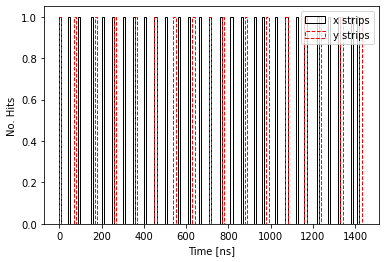

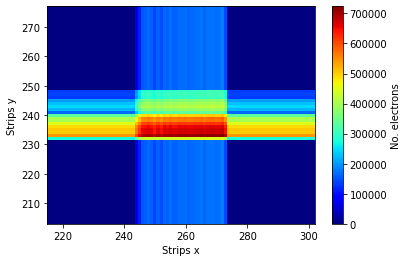

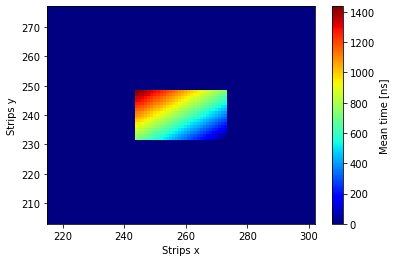

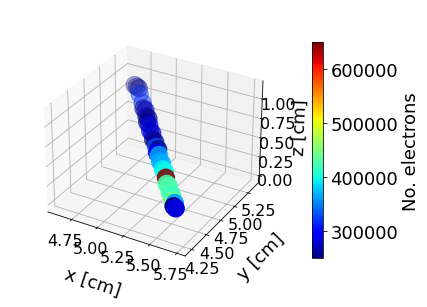

In [176]:
# 3D clustering paramters
mu = T_off.iloc[0]["Mu"]
sigma = T_off.iloc[0]["Sigma"]
n_sigma = 3

# Look at a single event after the cut
test_event = tracks.iloc[4]
# Make a TrackTools object for the event
dsp = stripROtools.TrackTools(event = test_event, Mult_factor = 1.0, gain_x=9, gain_y=4.5, v_drift=8.0)

# Plot 1D time display
dsp.TimeHistView( t_bin =10)

# Plot 2D displays of charge and time
dsp.Strip2DView(fullview = False)
dsp.Strip2DView_times(fullview = False)

# Plot 3D displays
x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma)